<a href="https://colab.research.google.com/github/arshpreetsingh134/NLP-Twitter-Sentiment-Analysis/blob/master/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Here, I am using the **Sentiment140** dataset consisting of 1.6 million tweets that have been tagged as either positive or negative.

In [2]:
# Make data directory if it doesn't exist

!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/training.1600000.processed.noemoticon.csv.zip -P data
!unzip -n -d data data/training.1600000.processed.noemoticon.csv.zip

--2020-07-18 11:30:53--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/training.1600000.processed.noemoticon.csv.zip
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85088192 (81M) [application/zip]
Saving to: ‘data/training.1600000.processed.noemoticon.csv.zip’

training.1600000.pr 100%[===================>]  81.15M  29.6MB/s    in 2.7s    

2020-07-18 11:30:56 (29.6 MB/s) - ‘data/training.1600000.processed.noemoticon.csv.zip’ saved [85088192/85088192]

Archive:  data/training.1600000.processed.noemoticon.csv.zip
  inflating: data/training.1600000.processed.noemoticon.csv  


In [3]:
df = pd.read_csv("data/training.1600000.processed.noemoticon.csv",
                names=['label', 'id', 'date', 'query', 'user', 'tweet'],
                encoding='latin-1')
df.head()

,label,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### There are currently **800,000 positive tweets** and **800,000 negative tweets** in this dataset.

In [4]:
df.label.value_counts()

4    800000
0    800000
Name: label, dtype: int64

### The current *label* column has values 0 for negative tweets and 4 for positive ones. For the sake of readability, I will change that to 0 and 1 respectively.

In [5]:
df.label = df.label.replace({0: 0, 4: 1})
df.label.value_counts()

1    800000
0    800000
Name: label, dtype: int64

### Now I will drop the unneeded columns from our DataFrame.

In [6]:
df = df.drop(columns = ['id', 'date', 'query', 'user'])
df.head()

,label,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### For the sake of simplicity, I will only train on a small random subset of **100,000 tweets.**

In [7]:
df = df.sample(n=100000)
df.label.value_counts()

0    50276
1    49724
Name: label, dtype: int64

In [8]:
df.to_csv("data/sentiment140-subset.csv", index=False)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 762476 to 1494552
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   100000 non-null  int64 
 1   tweet   100000 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [10]:
df.describe()

,label
count,100000.000000
mean,0.497240
std,0.499995
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


# **Data Visualization: Exploring the Dataset**

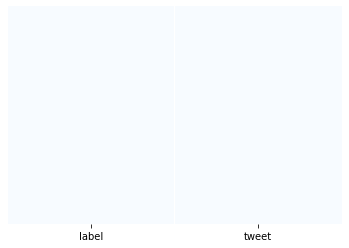

In [11]:
# The following Heat Map would display colored cells corresponding to NULL values in our dataset.

sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="Blues")     
# Apparently, there are no null values in our dataset.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f56127167b8>]],
      dtype=object)

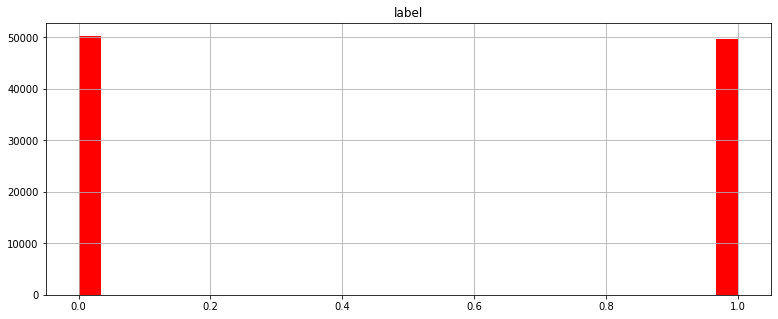

In [12]:
# Histogram

df.hist(bins=30, figsize=(13,5), color='r')

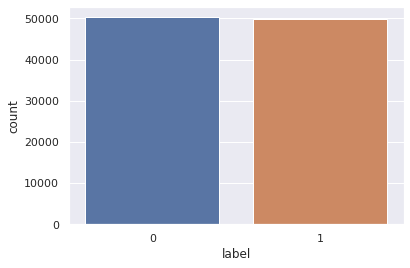

In [13]:
# Seaborn Countplot

sns.set(style="darkgrid")
ax = sns.countplot(x='label', data=df)
plt.show()

In [14]:
# Adding a column that keeps track of the number of words in a tweet...

df['length']= df['tweet'].apply(len)

In [15]:
df.head()

,label,tweet,length
762476,0,Where are &quot;original&quot; .NET OSS projec...,148
932380,1,@musicholic1997 nuthin's up Spaz itu apa?,42
119946,0,Earthquake!,12
937476,1,@magdalena90210 oh ok makes sense. well if u ...,135
398552,0,@lalachar lol i'm not sure how much he values ...,101


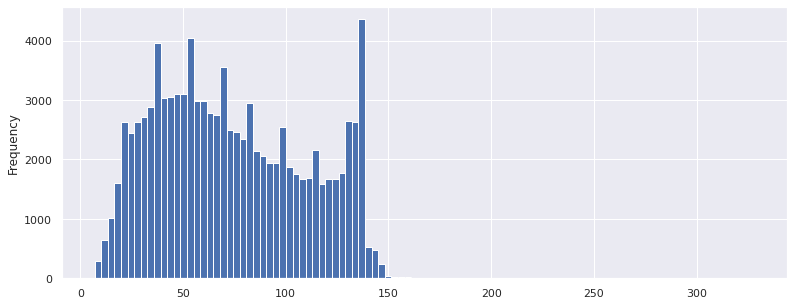

In [16]:
# Histogram for the length of tweets.

df['length'].plot(bins=100, figsize=(13,5), kind='hist')

In [17]:
df.describe()

,label,length
count,100000.000000,100000.000000
mean,0.497240,73.999420
std,0.499995,36.483652
min,0.000000,7.000000
25%,0.000000,44.000000
50%,0.000000,69.000000
75%,1.000000,104.000000
max,1.000000,328.000000


In [18]:
# Let's see the shortest tweet

df[df['length'] == 7]['tweet'].iloc[0]

'i suck '

In [55]:
# Let's see the tweet with the average length

df[df['length'] == 74]['tweet'].iloc[0]

'i wanna go back in the sun but lisi dragging me to the tv! babies  lolflex'

### Let's explore Positive and Negative tweets in our dataset.

In [20]:
positive = df[df['label']==1]
positive

,label,tweet,length
932380,1,@musicholic1997 nuthin's up Spaz itu apa?,42
937476,1,@magdalena90210 oh ok makes sense. well if u ...,135
1221325,1,Woohoo! Scored a DJ for the reception. For fre...,124
1010523,1,"@Ashley_Cameron From the look of the photo, a ...",59
1266293,1,"@Simple_Bliss Yeah, I did. It really wasn't as...",136
...,...,...,...
911460,1,P-Nutt got a new collar and leash today http:...,94
1374704,1,"@FoxxFiles Okay, I tried",25
1015102,1,i had a very nice day today,28
1138560,1,10:00pm He must be having fun because he hasn'...,133


In [21]:
negative = df[df['label']==0]
negative

,label,tweet,length
762476,0,Where are &quot;original&quot; .NET OSS projec...,148
119946,0,Earthquake!,12
398552,0,@lalachar lol i'm not sure how much he values ...,101
679873,0,Friday and no where to go,26
81862,0,one session in the gym and I'm having problem...,134
...,...,...,...
235250,0,@auschirp foolishly checked my bag in 'cos did...,114
103394,0,New modem arrived. Thank goodness. I felt so d...,58
756338,0,jesus christ.. you too @dgaf_princess?! I'm th...,97
553518,0,no-ones on so ill go off and use this time to ...,52


### **Plotting the Wordcloud for Positive and Negative Tweets**

In [22]:
sentences = df['tweet'].tolist()
sentences[:20]

["Where are &quot;original&quot; .NET OSS projects like Hadoop/WEKA/Lucene/etc (not just ports)? Seems like they're all just Mock/Test/IoC frameworks ",
 "@musicholic1997 nuthin's up  Spaz itu apa?",
 'Earthquake! ',
 '@magdalena90210 oh ok  makes sense. well if u ever need help with a lyric or production I can be of some assistance. Im also an artist.',
 "@lalachar lol i'm not sure how much he values his life at... mc was busy and big will-less  sad times",
 'Woohoo! Scored a DJ for the reception. For free.  Now just need to get equipment sorted, and entertainment is mostly done...',
 '@Ashley_Cameron From the look of the photo, a lot of buses ',
 "@Simple_Bliss Yeah, I did. It really wasn't as hard as everyone seemed to make it out to be, I just miss the occasional burger. Rarely. ",
 'Friday and no where to go ',
 " one session in the gym and I'm having problems with my leg again (slipped disc = sciatic pain). Will have to us my stick this week ((",
 "Can't wait for top gear tonight

In [23]:
len(sentences)

100000

In [24]:
sentences_as_string = " ".join(sentences)

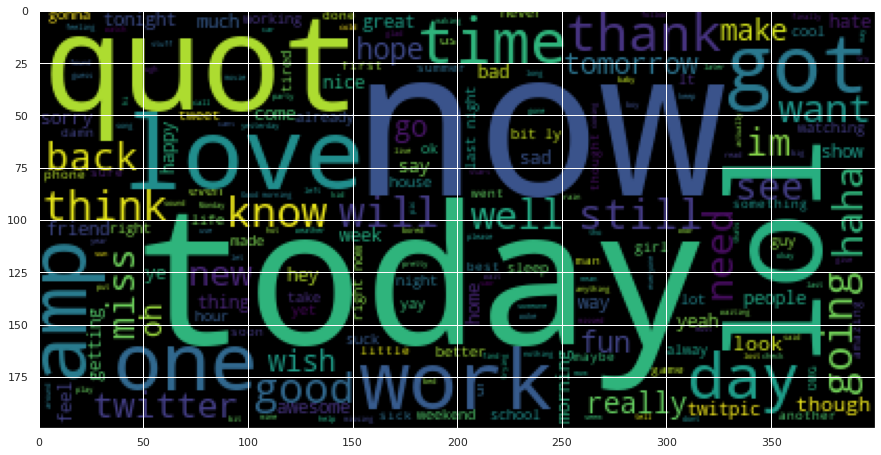

In [25]:
!pip install WordCloud
from wordcloud import WordCloud

plt.figure(figsize=(15,15))
plt.imshow(WordCloud().generate(sentences_as_string))

### Plotting Wordcloud of the "Positive" Dataframe

In [26]:
positive_sentences = positive['tweet'].tolist()
pos_sentences_as_string = " ".join(sentences)

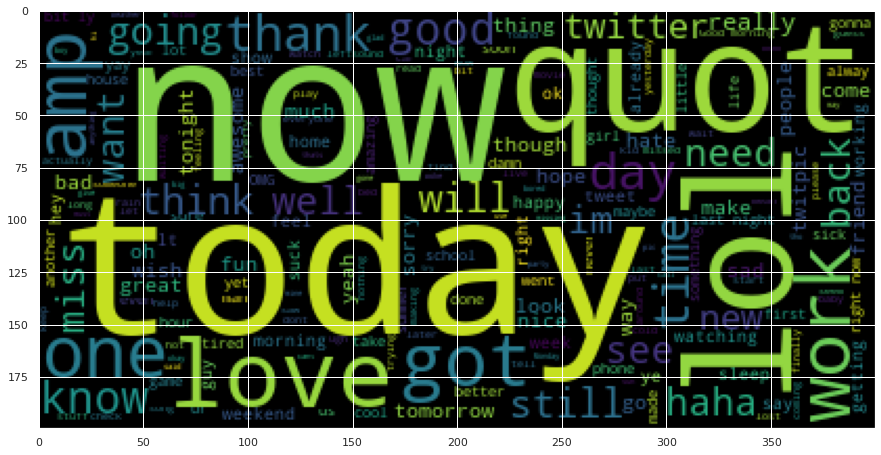

In [27]:
plt.figure(figsize=(15,15))
plt.imshow(WordCloud().generate(pos_sentences_as_string))

# The following WordCloud has been plotted using positive tweets only, so you will notice 
# mostly positive words in the WordCloud such as- 'good', 'thank', 'happy', 'well', 'love', etc.

### Plotting Wordcloud of the "Negative" Dataframe

In [28]:
negative_sentences = negative['tweet'].tolist()
neg_sentences_as_string = " ".join(sentences)

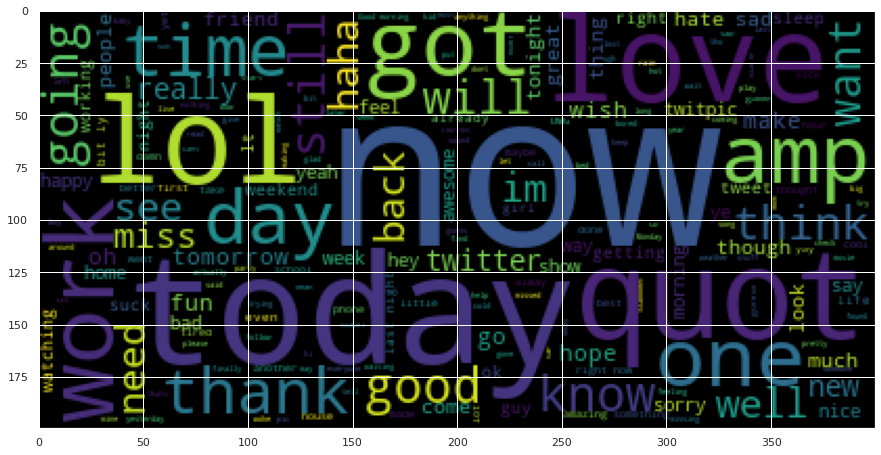

In [29]:
plt.figure(figsize=(15,15))
plt.imshow(WordCloud().generate(neg_sentences_as_string))

# The following WordCloud has been plotted using negative tweets only, so you will notice 
# mostly negative words in the WordCloud such as- 'sorry', 'suck', 'hate', 'sad', 'working', etc.

# **Data Cleaning (1) : Removing Punctuation**

In [30]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [31]:
Test_text = "Good Morning friends!!! I am Arshpreet from India.... ML is fun :)"

Here, I'll be using the function ***maketrans()*** to create an empty mapping table. The third argument of this function allows us to list all of the characters to remove during the translation process. I will include all the punctuation symbols using *string.punctuation*.

Python function ***translate()*** maps one set of characters to another.

In [32]:
words = Test_text.split()
table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table) for w in words]
print(stripped[:100])

['Good', 'Morning', 'friends', 'I', 'am', 'Arshpreet', 'from', 'India', 'ML', 'is', 'fun', '']


In [33]:
punc_remove_join_test = ' '.join(stripped)
punc_remove_join_test

'Good Morning friends I am Arshpreet from India ML is fun '

In [34]:
##### Alternate Method:- #####
# test_punc_removed = [char for char in Test_text if char not in string.punctuation]
# joined_test = ''.join(test_punc_removed)
# joined_test

# **Data Cleaning (2) : Removing Stopwords**

In [35]:
import nltk   #natural language toolkit
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [36]:
# Downloading stopwords Package

from nltk.corpus import stopwords
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [37]:
data_cleaned = [word for word in punc_remove_join_test.split() if word.lower() not in stopwords.words('english')]
data_cleaned

['Good', 'Morning', 'friends', 'Arshpreet', 'India', 'ML', 'fun']

# **Data Cleaning (3) : Performing Count Vectorization**

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
sample_data = ['This is my computer.', 'This laptop is a computer.', 'This computer is my computer.']

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(sample_data)

In [39]:
print(vectorizer.get_feature_names())

['computer', 'is', 'laptop', 'my', 'this']


In [40]:
print(X.toarray())

[[1 1 0 1 1]
 [1 1 1 0 1]
 [2 1 0 1 1]]


# **Now I'll create a single NLP Data Preprocessing Pipeline to remove punctuations, stopwords, and perform Count Vectorization**

In [41]:
def data_preprocess(tweet):

  # Removing Usernames using regexp
  tweet = re.sub('@[^\s]+','',tweet)
  
  # Removing Punctuation
  words = tweet.split()
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in words]
  test_punc_removed = ' '.join(stripped)

  # Removing Stopwords
  test_punc_removed_clean = [word for word in test_punc_removed.split() if word.lower() not in stopwords.words('english')]

  return test_punc_removed_clean

In [42]:
# Let's test this function on our original dataset
#tweets_cleaned = df['tweet'][15].apply(data_preprocess)
#print(tweets_cleaned['tweet'][15])    # Cleaned-up Version
#print(tweets_cleaned['tweet'][687])

In [43]:
#print(df['tweet'][15])    # Original Version
#print(df['tweet'][687])

In [44]:
vectorizer = CountVectorizer(analyzer = data_preprocess, dtype='uint8')
tweets_vectorizer = vectorizer.fit_transform(df['tweet'])

In [45]:
import random
print(random.sample(vectorizer.get_feature_names(), 250))   # For randomly showing 250 words out of the corpus

['dollar', 'wishn', 'inevitable', 'phonebummer', 'missu', 'mmmhere', 'testen', 'sadand', 'GIRLgt', 'twittergetter', 'nowsome', 'small', 'æ¸', 'Chyeah', 'considered', 'nibbleos', 'cf', 'americanquot', 'Hopnoxious', 'dave', 'ZNews', 'algebra', 'spellcheck', 'canary', 'Quest', 'goodit', 'unsyncd', 'Pix', 'LOLed', 'httptwitpiccom5f3q4', '49', 'Jamies', 'atualizaÃ§Ã£o', 'luff', 'Cramping', 'YAAAARRRGH', 'gosshhh', 'Base', 'back5', 'starring', 'Sut', 'quotsit', '5of', 'Soso', 'heartsucker', 'frother', 'bodies', 'tratior', 'aa', 'bananas', 'wire', 'httpplurkcomp11kjx0', 'httpyfrogcom5jt94j', 'httptwitpiccom6nbw4', 'stakes', 'screeched', 'reuploading', 'truenothing', 'africa', 'Angela', 'quotsee', 'fairly', 'awesomeeeee', 'Odee', 'BSC', 'Remarkable', 'LU', 'Awwmy', 'LMBO', 'cs', 'bias', 'wii', 'Princesses', 'backbut', 'muchquot', 'whatta', 'Skiba', 'httptwitpiccom69725', 'berlin', 'thursdaypoor', 'ecocafe', 'wMaria', 'BlueDart', 'mindstsk', 'beb', 'drag', 'sugartits', 'upgtgt', 'assumes', 'Ð¿Ð

In [46]:
print(tweets_vectorizer.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [47]:
tweets_vectorizer.shape

(100000, 87581)

In [48]:
X = tweets_vectorizer
y = df['label']

# **Training a Naive-Bayes Classifier Model**

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [50]:
from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

# **Analyzing Trained Model's Performance**

In [51]:
from sklearn.metrics import classification_report, confusion_matrix

### Confusion Matrix

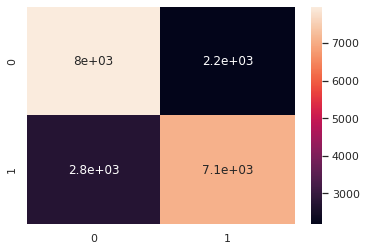

In [56]:
y_test_predict = NB_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_test_predict)
sns.heatmap(cm, annot=True)

# There are 2200 False Positives and 2800 False Negatives in my NLP model.

### Classification Report

In [53]:
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.74      0.79      0.76     10141
           1       0.77      0.72      0.74      9859

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000



In [54]:
print(NB_classifier.predict(X_test[:3]))

[1 1 0]


## I got an accuracy of **75%** on my Naive-Bayes Model!!!